In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem, ttest_rel, pearsonr

from funcs_loadData import *
from taskSetting import DIMENSIONS

/Users/mingyusong/anaconda3/envs/rule-learning/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load data
expVersion = 'all'
data, workerIds = load_data(expVersion, getWorkerIds=True)

## Answer

In [3]:
# collect post game answers
from collections import defaultdict

dataGame = data[data['trial']==1]
postGameAnswer = defaultdict(list)

postGameAnswer['workerId'] = dataGame['workerId'].values
postGameAnswer['game'] = dataGame['game'].values
postGameAnswer['numRelevantDimensions'] = dataGame['numRelevantDimensions'].values
postGameAnswer['informed'] = dataGame['informed'].values

postGameAnswer['add_postGameQ_numDimReported'] = pd.concat([(dataGame['postGameAnswer_' + dim] != 'not-important').astype(int) for dim in DIMENSIONS], axis=1, keys=DIMENSIONS).sum(axis=1).values
postGameAnswer['add_postGameQ_correctFeature'] = pd.concat([((~dataGame['rewardingFeature_' + dim].isnull()) & (
                        dataGame['postGameAnswer_' + dim] == dataGame['rewardingFeature_' + dim])).astype(int) for
                                          dim in DIMENSIONS], axis=1, keys=DIMENSIONS).sum(axis=1).values
postGameAnswer['add_postGameQ_wrongFeature'] = pd.concat([((~dataGame['rewardingFeature_' + dim].isnull()) & (
                        dataGame['postGameAnswer_' + dim] != 'not-important') & (
                        dataGame['postGameAnswer_' + dim] != dataGame['rewardingFeature_' + dim])).astype(
                            int) for dim in DIMENSIONS], axis=1, keys=DIMENSIONS).sum(axis=1).values
postGameAnswer['add_postGameQ_ignoreFeature'] = pd.concat([((~dataGame['rewardingFeature_' + dim].isnull()) & (
                        dataGame['postGameAnswer_' + dim] == 'not-important')).astype(int) for dim in DIMENSIONS], axis=1,
                                keys=DIMENSIONS).sum(axis=1).values
postGameAnswer['add_postGameQ_falsePositive'] = pd.concat([((dataGame['rewardingFeature_' + dim].isnull()) & (
                        dataGame['postGameAnswer_' + dim] != 'not-important')).astype(int) for
                                                           dim in DIMENSIONS], axis=1, keys=DIMENSIONS).sum(axis=1).values
postGameAnswer['add_postGameQ_correctReject'] = pd.concat([((dataGame['rewardingFeature_' + dim].isnull()) & (
                        dataGame['postGameAnswer_' + dim] == 'not-important')).astype(int) for
                                dim in DIMENSIONS], axis=1, keys=DIMENSIONS).sum(axis=1).values

postGameAnswerDF = pd.DataFrame(postGameAnswer)

### Fig 2C

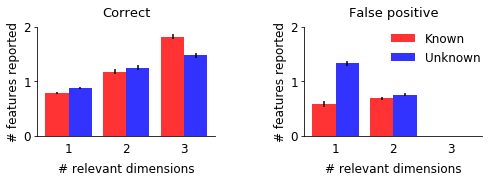

In [4]:
# plot correct feature and false positive

plt.rcParams.update({'font.size': 12})

labels = {
    'add_postGameQ_correctFeature': 'Correct',
    'add_postGameQ_falsePositive': 'False positive'
}

fig, axes = plt.subplots(1, 2, figsize=(7, 2.7), sharex=True)
for i, varName in enumerate(['add_postGameQ_correctFeature', 'add_postGameQ_falsePositive']):
    ax = axes[i]
    for numRelevantDimensions in np.arange(len(DIMENSIONS)) + 1:
        for informed in [True, False]:
            tmp = postGameAnswerDF[(postGameAnswerDF['numRelevantDimensions'] == numRelevantDimensions) & (postGameAnswerDF['informed'] == informed)]
            mean = tmp.groupby('workerId')[varName].mean().mean()
            se = tmp.groupby('workerId')[varName].mean().agg('sem')
            p = ax.bar(x=numRelevantDimensions + (-0.2 if informed else 0.2), height=mean, width=0.4, yerr=se,
                        color='red' if informed else 'blue',
                        label=('Known' if informed else 'Unknown') if numRelevantDimensions == 1 else None, alpha=.8)
    ax.set_xticks([1, 2, 3])
    ax.spines['bottom'].set_position('zero')
    sns.despine()
    ax.tick_params(axis='x', length=0, pad=7)
    ax.tick_params(axis='y', length=3)
    ax.set_xlabel(xlabel='# relevant dimensions', labelpad=7)
    ax.set_ylabel(ylabel='# features reported', labelpad=3)
    ax.set_title(labels[varName], pad=10, fontsize=13)
    ax.set(ylim=[-0.01, 2], yticks=[0,1,2])
    if varName == 'add_postGameQ_falsePositive':
        ax.legend(frameon=False, bbox_to_anchor=(1.05, 1.05))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

In [5]:
def getMeanSEM(df, varName):
    results = df.sort_values('informed', ascending=False).sort_values('numRelevantDimensions', ascending=True).groupby(
        ['numRelevantDimensions', 'informed'], sort=False).agg({varName: [np.nanmean, sem]})[varName]
    return results['nanmean'], results['sem']


def plotStackBars(ax, df, varNameList, xvalues, barWidth, colors):
    p = []
    for idx, varName in enumerate(varNameList):
        meanValue, semValue = getMeanSEM(df, varName)
        if idx == 0:
            p.append(ax.bar(xvalues, meanValue, width=barWidth, yerr=semValue, color=colors[idx], edgecolor='k', alpha=0.7))
            sumMean = meanValue
        else:
            p.append(ax.bar(xvalues, meanValue, width=barWidth, yerr=semValue, bottom=sumMean, color=colors[idx], edgecolor='k', alpha=0.7))
            sumMean += meanValue
    return p

### Fig S1C

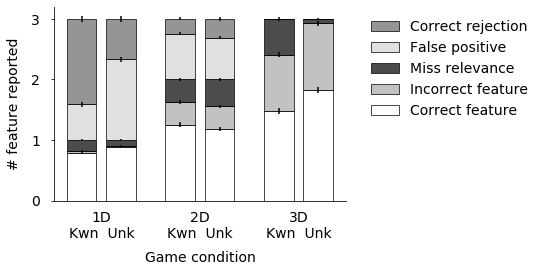

In [6]:
# plot all responses
plt.rcParams.update({'font.size': 14})
colors = ['white', 'lightgray', 'darkgray', 'dimgray', 'black']
colors = [colors[i] for i in np.array([1,3,5,2,4])-1]
barWidth = 0.3
offset = 0.2
xvalues = [1-offset, 1+offset, 2-offset, 2+offset, 3-offset, 3+offset]
varNameList = ['add_postGameQ_' + varName for varName in ['correctFeature', 'wrongFeature', 'ignoreFeature', 'falsePositive', 'correctReject']]
varLabels = ['Correct feature', 'Incorrect feature', 'Miss relevance', 'False positive', 'Correct rejection']
fig, ax = plt.subplots(figsize=(8, 4))
p = plotStackBars(ax, postGameAnswerDF, varNameList, xvalues, barWidth, colors)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['1D\nKwn  Unk', '2D\nKwn  Unk', '3D\nKwn  Unk'], rotation=0)
ax.tick_params(axis='x', length=0, pad=10)
ax.tick_params(axis='y', pad=10)
ax.set_xlabel('Game condition', labelpad=10)
ax.set_ylabel('# feature reported', labelpad=10)
plt.legend(handles=p[::-1], labels=varLabels[::-1], bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

In [7]:
## stats

# paired t-test: correctFeature against informed
for var in ['add_postGameQ_correctFeature', 'add_postGameQ_falsePositive']:
    print(var)
    for numRD in np.arange(numDimensions)+1:
        df = postGameAnswerDF[(postGameAnswerDF['numRelevantDimensions'] == numRD)]
        t, p = ttest_rel(df[df['informed'] == True].groupby('workerId').mean()[var], df[df['informed'] == False].groupby('workerId').mean()[var])
        print(str(numRD) + 'D: t =', t, ', p =', p)

add_postGameQ_correctFeature
1D: t = -3.6422794579407696 , p = 0.0004285247365425721
2D: t = -1.2740448699795508 , p = 0.20557137255535926
3D: t = 4.857186412725099 , p = 4.360063762044976e-06
add_postGameQ_falsePositive
1D: t = -10.962120492438691 , p = 6.877655811445807e-19
2D: t = -1.7187437681027171 , p = 0.08872477562972317
3D: t = nan , p = nan


In [8]:
# anova

from statsmodels.stats.anova import AnovaRM

for var in ['add_postGameQ_correctFeature', 'add_postGameQ_falsePositive']:
    d = postGameAnswerDF if var == 'add_postGameQ_correctFeature' else postGameAnswerDF[postGameAnswerDF['numRelevantDimensions']<=2]
    aovrm = AnovaRM(data=d, depvar=var, subject='workerId', within=['numRelevantDimensions', 'informed'], aggregate_func=np.nanmean)
    result = aovrm.fit()
    print(var + '\n', result)

add_postGameQ_correctFeature
                             Anova
                               F Value  Num DF  Den DF  Pr > F
--------------------------------------------------------------
numRelevantDimensions          273.7047 2.0000 202.0000 0.0000
informed                         3.0653 1.0000 101.0000 0.0830
numRelevantDimensions:informed  21.3010 2.0000 202.0000 0.0000

add_postGameQ_falsePositive
                             Anova
                               F Value Num DF  Den DF  Pr > F
-------------------------------------------------------------
numRelevantDimensions          32.0470 1.0000 101.0000 0.0000
informed                       93.2606 1.0000 101.0000 0.0000
numRelevantDimensions:informed 90.7926 1.0000 101.0000 0.0000



## Confidence level

In [9]:
data['n_correct_question'] = np.sum([(data['postGameAnswer_'+dim]==data['rewardingFeature_'+dim])|(~data['ifRelevantDimension_color']&(data['postGameAnswer_'+dim]=='not-important')) for dim in DIMENSIONS], axis=0)
agg = data.groupby(['workerId','informed','numRelevantDimensions']).mean()[['postGameConfidence_'+dim for dim in DIMENSIONS] + ['reward', 'n_correct_question']].reset_index()
agg['confidence'] = agg[['postGameConfidence_'+dim for dim in DIMENSIONS]].mean(axis=1)

In [10]:
agg

,workerId,informed,numRelevantDimensions,postGameConfidence_color,postGameConfidence_shape,postGameConfidence_pattern,reward,n_correct_question,confidence
0,1,False,1,74.000000,66.666667,74.666667,0.666667,1.333333,71.777778
1,1,False,2,76.666667,59.333333,83.000000,0.573034,1.333333,73.000000
2,1,False,3,67.000000,66.000000,49.666667,0.477778,1.666667,60.888889
3,1,True,1,88.666667,69.000000,74.000000,0.622222,2.666667,77.222222
4,1,True,2,36.000000,39.000000,27.666667,0.555556,0.666667,34.222222
...,...,...,...,...,...,...,...,...,...
607,106,False,2,48.666667,50.333333,59.000000,0.477273,1.666667,52.666667
608,106,False,3,59.666667,25.333333,46.666667,0.459770,1.000000,43.888889
609,106,True,1,66.333333,66.666667,67.000000,0.588889,1.333333,66.666667
610,106,True,2,30.000000,59.000000,49.000000,0.588889,2.000000,46.000000


Text(0.5, 0, '# correct answers')

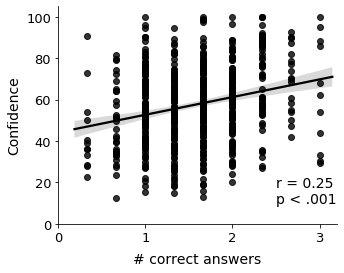

In [11]:
fig, ax = plt.subplots(figsize=(5,4),sharex=True, sharey=True)

r, p = pearsonr(agg['confidence'], agg['n_correct_question'])
sns.regplot(y='confidence', x='n_correct_question', color='k', data=agg, fit_reg=p<.05, ax=ax)
ax.set(ylim=[0,105], xlim=[0,3.2])
p_text = f'p = {np.round(p,3)}' if p > .001 else 'p < .001'
ax.text(2.5, 10, f'r = {np.round(r,2)}\n{p_text}', fontsize=14)
sns.despine()
ax.set_ylabel('Confidence', fontsize=14, labelpad=5)
ax.set_yticklabels(labels=[0,20,40,60,80,100], fontsize=13)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels=[0,1,2,3], fontsize=13)
ax.set_xlabel('# correct answers', fontsize=14, labelpad=8)

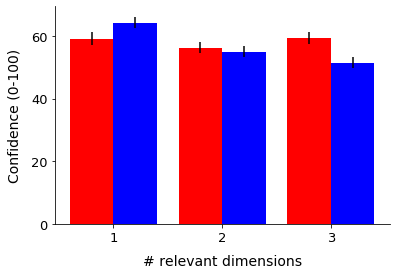

In [12]:
fig, ax = plt.subplots()

for numRelevantDimension in np.arange(numDimensions)+1:
    for informed in [True, False]:
        tmp = agg[(agg['informed'] == informed) & (agg['numRelevantDimensions'] == numRelevantDimension)]
        x = numRelevantDimension + (-0.2 if informed else 0.2)
        mean = np.mean(tmp['confidence'])
        sem = np.std(tmp['confidence']) / np.sqrt(tmp.shape[0])
        ax.bar(x=x, height=mean, width=0.4, color='r' if informed else 'b')
        ax.errorbar(x=x, y=mean, yerr=sem, lineStyle=None, color='k')
        ax.set_xticks([1,2,3])
        ax.set_xlabel('# relevant dimensions', fontsize=14, labelpad=10)
        ax.set_ylabel('Confidence (0-100)', fontsize=14, labelpad=10)
        ax.set_xticklabels(labels=[1,2,3], fontsize=13)
        ax.set_yticks([0,20,40,60])
        ax.set_yticklabels(labels=[0,20,40,60], fontsize=13)
        sns.despine()

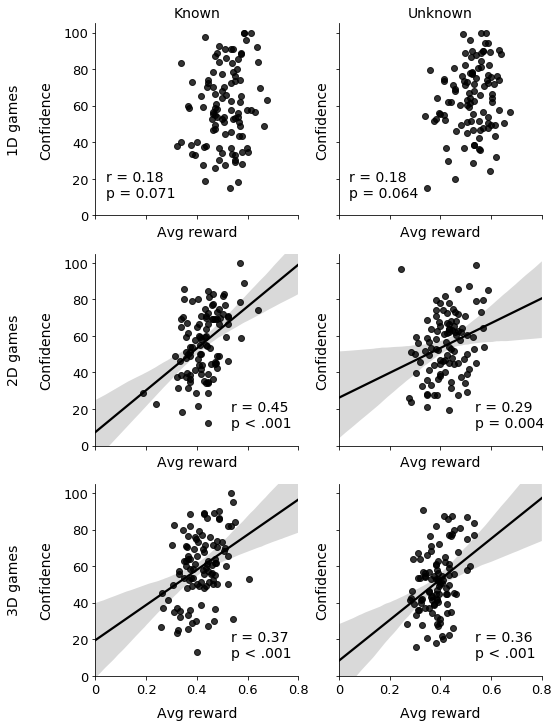

In [13]:
fig, axes = plt.subplots(3,2,figsize=(8,12), sharex=True, sharey=True)

for i1, numRelevantDimension in enumerate(np.arange(numDimensions)+1):
    for i2, informed in enumerate([True, False]):
        ax = axes[i1, i2]
        tmp = agg[(agg['informed'] == informed) & (agg['numRelevantDimensions'] == numRelevantDimension)]
        r, p = pearsonr(tmp['reward'], tmp['confidence'])
        sns.regplot(y='confidence', x='reward', color='k', data=tmp, fit_reg=p<.05, ax=ax)
        ax.set(ylim=[0,105], xlim=[0,1])
        p_text = f'p = {np.round(p,3)}' if p > .001 else 'p < .001'
        ax.text(0.05 if numRelevantDimension==1 else 0.67, 10, f'r = {np.round(r,2)}\n{p_text}', fontsize=14)
        sns.despine()
        ax.set_xlabel('Avg reward', fontsize=14, labelpad=10)
        ax.set_yticklabels(labels=[0,20,40,60,80,100], fontsize=13)
        ax.set_xticklabels(labels=[0,0.2,0.4,0.6,0.8,1], fontsize=13)
        if i1 == 0:
            ax.set_title('Known' if i2 == 0 else 'Unknown', fontsize=14)
        if i2 == 0:
            ax.set_ylabel(f'{numRelevantDimension}D games\n\nConfidence', fontsize=14, labelpad=10)
        else:
            ax.set_ylabel('Confidence', fontsize=14, labelpad=10)
        